<a href="https://colab.research.google.com/github/JonasZaoui/test/blob/main/modelcmbs_labelsampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*   Model avec LabelSampler en patchsize = (128x128x32) 
*   Loss = DiceCELoss







In [1]:
!pip install -q torchio==0.18.75
!pip install -q monai==0.8.1
!pip install -q pytorch-lightning==1.5.10
!pip install -q gdown==3.6.4 matplotlib==3.2.2 pandas==1.1.5 seaborn==0.11.1

     |████████████████████████████████| 164 kB 4.9 MB/s 
     |████████████████████████████████| 48.4 MB 3.4 MB/s 
     |████████████████████████████████| 721 kB 4.9 MB/s 
     |████████████████████████████████| 527 kB 5.0 MB/s 
     |████████████████████████████████| 829 kB 61.6 MB/s 
     |████████████████████████████████| 952 kB 35.0 MB/s 
     |████████████████████████████████| 140 kB 75.2 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 419 kB 76.9 MB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 67.2 MB/s 
     |████████████████████████████████| 271 kB 76.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

In [2]:
import monai 
import matplotlib.pyplot as plt
import torchio as tio
import time
import pandas as pd
from datetime import datetime
import torch 
import torchvision
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import random_split, DataLoader
import os
from IPython import display

import random


plt.rcParams['figure.figsize'] = 12, 8

print('Last run on', time.ctime())

%reload_ext tensorboard


Last run on Wed Jun 15 11:30:52 2022


In [3]:
print(tio.__version__)
print(torch.__version__)
print(torchvision.__version__)
print(monai.__version__)
print(pl.__version__)



0.18.75
1.11.0+cu113
0.12.0+cu113
0.8.1
1.5.10


In [107]:
class Dataset(pl.LightningDataModule):
    def __init__(self,dataset_dir,batch_size,train_val_ratio):
        super().__init__()
        self.batch_size = batch_size
        self.dataset_dir = Path(dataset_dir)
        self.subjects = None
        self.train_val_ratio = train_val_ratio
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    
    def download_data(self):
       
        def get_niis(d):
            return sorted(p for p in d.glob('*.nii*') if not p.name.startswith('.'))

        image_training_paths = get_niis(self.dataset_dir / 'mri_cropped')
        label_training_paths = get_niis(self.dataset_dir / 'label_cropped')
        return image_training_paths, label_training_paths

    def prepare_data(self):
        image_training_paths, label_training_paths = self.download_data()

        self.subjects = []
        for image_path, label_path in sorted(zip(image_training_paths, label_training_paths)):
            subject = tio.Subject(
                image=tio.ScalarImage(image_path),
                label=tio.LabelMap(label_path),
                name = os.path.basename(image_path)
            )
            self.subjects.append(subject)

        
    
    def get_preprocessing_transform(self):
        preprocess = tio.Compose([
            tio.RescaleIntensity((-1, 1)),
            tio.Pad((48,48,48)), #!!!!!!!!!!
        ])
        return preprocess


    # def get_preprocessing_transform(self):
    #     preprocess = tio.RescaleIntensity((-1, 1))
    #     return preprocess
        
    def get_augmentation_transform(self):
        augment = tio.RandomGamma(p=0.5)
        return augment

    def setup(self,stage=None,cmbs_in_train=None):
        

        with_cmbs = [17,43,45,51,58,60] #liste des indexes avec bcp de cmbs
        subjects_with_cmbs = [self.subjects[i] for i in with_cmbs] #On récupère les sujets avec le plus de microbleeds
        num_subjects1 = len(self.subjects) #86

        for i in with_cmbs:
          self.subjects.pop(i) #on retire ces éléments

        num_train_subjects = int(round(num_subjects1* self.train_val_ratio)) #70
        num_val_subjects = num_subjects1 - num_train_subjects #16

        train_subjects = []
        val_subjects = []

      
        if cmbs_in_train == True : #Si on veut les cmbs dans le train 
          train_subjects += subjects_with_cmbs #on ajoute les éléments avec bcp de cmbs
          random.shuffle(self.subjects) # on shuffle le reste des sujets 
          i=0
          while len(train_subjects)<num_train_subjects:
            train_subjects+=[self.subjects[i]] # on rajoute des sujets
            i+=1
          val_subjects = self.subjects[i:] # le reste non sélectionné va dans le val_set 

        else : 
          val_subjects += subjects_with_cmbs
          random.shuffle(self.subjects)
          i=0
          while len(val_subjects)<num_val_subjects:
            val_subjects+=[self.subjects[i]]
            i+=1
          train_subjects = self.subjects[i:]



        self.preprocess = self.get_preprocessing_transform()
        augment = self.get_augmentation_transform()
        self.transform = tio.Compose([self.preprocess, augment])

        self.train_set = tio.SubjectsDataset(train_subjects, transform=self.transform) #data augmentation only on the trainset. 
        self.val_set = tio.SubjectsDataset(val_subjects, transform=self.preprocess)

        names_train = [subject.name for subject in data.train_set.dry_iter()] 
        names_valid= [subject.name for subject in data.val_set.dry_iter()]

        print('*'*50)
        print("Subjects for Training ",names_train)
        print("Subjects for Validation ",names_valid)
        print('*'*50)


        

    def train_dataloader(self):
        patches_queue_train = tio.Queue(self.train_set,max_length=60,samples_per_volume=20,sampler=tio.data.LabelSampler(patch_size=(96,96,96)),num_workers=0)  #!!!!!!!!!!
        patches_loader_train = DataLoader(patches_queue_train,self.batch_size,num_workers=0) 

        return patches_loader_train


    def val_dataloader(self):
        patches_queue_val = tio.Queue(self.val_set,max_length=60,samples_per_volume=20,sampler=tio.data.LabelSampler(patch_size=(96,96,96)),num_workers=0) #!!!!!!!!!!
        patches_loader_val = DataLoader(patches_queue_val,self.batch_size,num_workers=0)  

  

        return patches_loader_val

In [108]:
data = Dataset(
    dataset_dir = '/content/drive/MyDrive/test/',
    batch_size=16, #Batch SIze de 4 ? 
    train_val_ratio=0.8

)

In [109]:

data.prepare_data()
data.setup(cmbs_in_train=False)
print('Training:  ', len(data.train_set))
print('Validation: ', len(data.val_set))

**************************************************
Subjects for Training  ['sub-311_space-T2S_preprocessed.nii', '0200081MONO_space-T2S_preprocessed2.nii', 'sub-322_space-T2S_preprocessed.nii', 'sub-327_space-T2S_preprocessed.nii', '0040039LIEL_space-T2S_preprocessed2.nii', 'sub-319_space-T2S_preprocessed.nii', '0040027HEJE_space-T2S_preprocessed2.nii', '0130014JAAN_space-T2S_preprocessed2.nii', '0040135BRGU_space-T2S_preprocessed2.nii', 'sub-317_space-T2S_preprocessed.nii', 'sub-320_space-T2S_preprocessed.nii', '0130021BLCO_space-T2S_preprocessed2.nii', 'sub-111_space-T2S_preprocessed.nii', '0350004JEMI_space-T2S_preprocessed2.nii', 'sub-318_space-T2S_preprocessed.nii', 'sub-303_space-T2S_preprocessed.nii', '0010070CAAN_space-T2S_preprocessed2.nii', '0350015DEJE_space-T2S_preprocessed2.nii', '0200173GULO_space-T2S_preprocessed2.nii', '0040061FAMO_space-T2S_preprocessed2.nii', 'sub-316_space-T2S_preprocessed.nii', '0130020LORO_space-T2S_preprocessed2.nii', '0010041HUFR_space-T2S_prepro

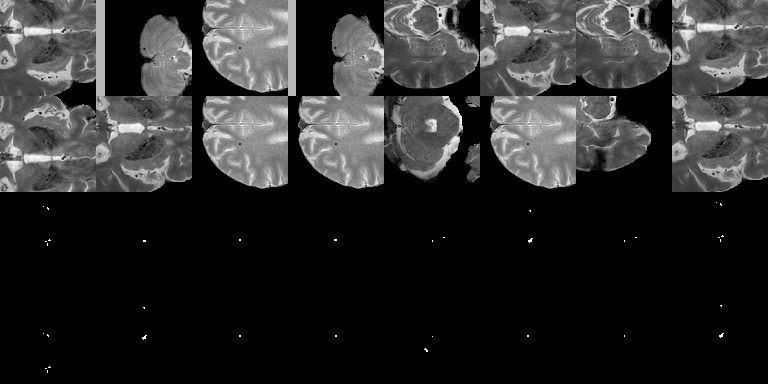

In [111]:
patches_loader_train = data.train_dataloader()
one_batch = next(iter(patches_loader_train))

k = 48
batch_mri = one_batch['image'][tio.DATA][..., k]
batch_label = one_batch['label'][tio.DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = '/content/batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=16//2,
    normalize=True,
    scale_each=True,
    padding=0,
)
display.Image(image_path)

In [ ]:
# import nibabel as nib
# import numpy as np

# patches_loader_train = data.train_dataloader()
# one_batch = next(iter(patches_loader_train))

# for i,image in enumerate(one_batch['image'][tio.DATA]):
#   img = image.squeeze().cpu().numpy()
#   ni_img = nib.Nifti1Image(img, affine=np.eye(4))
#   nib.save(ni_img, '/content/MRI_TEST2_'+str(i)+'.nii')

# for i,image in enumerate(one_batch['label'][tio.DATA]):
#   img = image.squeeze().cpu().numpy()
#   ni_img = nib.Nifti1Image(img, affine=np.eye(4))
#   nib.save(ni_img, '/content/LABEL_TEST2_'+str(i)+'.nii')


In [112]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate #pas d'apprentissage pour optimiseur
        self.net = net #model utilisé 
        self.criterion = criterion #fonction cout a minimiser
        self.optimizer_class = optimizer_class #Optimiseur choisi
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr) #On applique l'optimiseur aux paramètres du modele
        return optimizer
    
    def prepare_batch(self, batch):
        return batch['image'][tio.DATA], batch['label'][tio.DATA]
    
    def infer_batch(self, batch): # calcul l'erreur entre la sortie du model et le label. 
        x, y = self.prepare_batch(batch) 
        y_hat = self.net(x) #prediction
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch) # recupere la prediction et le label
        loss = self.criterion(y_hat, y) #calcul la perte entre les 2
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss



In [ ]:


#les patchs sont en 64x64x16
#les images sont en 208x208x48


# tb_logger = pl.loggers.TensorBoardLogger(save_dir="/network/lustre/iss02/cati/collabs/cmbs/training_jonas/log")


unet = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1, 
    channels=(64,128,256,512,1024), #!!!!!!!!!!
    strides=(2, 2, 2,2),
)



model = Model(
    net=unet,
    criterion=monai.losses.DiceLoss(sigmoid=True,include_background=False,batch=True),#!!!!!!!!!!
    learning_rate=1e-4,
    optimizer_class=torch.optim.AdamW,
)
 # batch = True  whether to sum the intersection and union areas over the batch dimension before the dividing. 
 # Defaults to False, intersection over union is computed from each item in the batch.







# early_stopping = pl.callbacks.early_stopping.EarlyStopping(
#     monitor='val_loss',
# )

# trainer = pl.Trainer( 
#     gpus=1, 
#     precision=16, #!!!!!!!!!!!
#     callbacks=[early_stopping],
# )

trainer = pl.Trainer( 
    gpus=1, 
    precision=16,
    max_epochs=60, #!!!!!!!!!!!
    # logger=tb_logger
)

trainer.logger._default_hp_metric = False




Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
start = datetime.now()
print('Training started at', start)
trainer.fit(model=model, datamodule=data)
print('Training duration:', datetime.now() - start)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | net       | UNet     | 31.6 M
1 | criterion | DiceLoss | 0     
---------------------------------------
31.6 M    Trainable params
0         Non-trainable params
31.6 M    Total params
63.274    Total estimated model params size (MB)


Training started at 2022-06-14 09:41:17.165187


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/monai/losses/dice.py:150: UserWarning: single channel prediction, `include_background=False` ignored.
  warnings.warn("single channel prediction, `include_background=False` ignored.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training duration: 0:47:53.269728


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
# DAns la progression bar, c'est le nb total de batch en train+val.

In [ ]:
%tensorboard --logdir lightning_logs

In [ ]:
len(patch_loader)

70

In [ ]:
with torch.no_grad():
    for batch in data.val_dataloader():
        inputs = batch['image'][tio.DATA].to(model.device)
        labels = model.net(inputs)
        for i in range(len(inputs)):
            break
        break   
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

RuntimeError: ignored

In [ ]:
with torch.no_grad():
    for batch in data.val_dataloader():
        inputs = batch['image'][tio.DATA].to(model.device)
        labels = torch.sigmoid(model.net(inputs))
        break   
print(batch.)
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

{'image': {'data': tensor([[[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

          [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.000

RuntimeError: ignored

In [ ]:
for subjects_batch in training_loader:
    tio_subj = tio.utils.get_subjects_from_batch(subjects_batch)[0]
    tio_subj = tio_subj.apply_inverse_transform()
    print('raw shape: {}'.format(subject_a.t1.shape))
    print('new shape: {}'.format(tio_subj.brain.shape))

In [ ]:
one_batch = next(iter(data.val_dataloader()))
inputs = batch['image'][tio.DATA].to(model.device)
labels = torch.sigmoid(model.net(inputs))



In [ ]:
torch.unique(labels)

tensor([0.0000e+00, 3.0368e-39, 3.7766e-39,  ..., 7.6763e-01, 8.4576e-01,
        9.6304e-01], grad_fn=<Unique2Backward0>)

In [ ]:
labels.size()

torch.Size([4, 1, 128, 128, 32])

In [ ]:
one_pred = labels[1,...] 
print(one_pred.size())
one_pred = one_pred.squeeze()
print(one_pred.size())

torch.Size([1, 128, 128, 32])
torch.Size([128, 128, 32])


In [ ]:
one_pred = one_pred.cpu().detach().numpy()
type(one_pred)

numpy.ndarray

In [ ]:
import nibabel as nib
import numpy as np
ni_img = nib.Nifti1Image(one_pred, affine=np.eye(4))
nib.save(ni_img, "dicom_volume_image.nii")

In [ ]:
model.net()

TypeError: ignored

In [ ]:
print(f'Number of epochs {trainer.max_epochs}')


Number of epochs 400


In [ ]:
print(f'Number of num_workers {data.val_dataloader().num_workers}')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Number of num_workers 0


In [ ]:
unet.channels

(64, 128, 256, 512, 1024)

In [ ]:
print(model.hparams)